### Show Input Sample
Our network receives a video of blinking emitters as input. Each video contains a pre-determined number of frames and the number of emitters we observe is bounded by another pre-determined parameter - maxSources.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import h5py
import os
import pickle

import dataset_NEWtf

def loadDataObj(path, set_str):
    with open(os.path.join(path, set_str + '.obj'), 'rb') as dataFile:
        dataObj = pickle.load(dataFile)
    return dataObj

def pickSample(dataObj):
    numSamples = dataObj.labels.shape[0]
    randIDx = np.random.randint(numSamples)
    featureSample = dataObj.features[randIDx,:,:,:]
    labelSample = dataObj.labels[randIDx,:,:,:]
    return featureSample, labelSample
       
def printSampleParams(input_sample):
    imgSize, _, numFrames = np.shape(input_sample[0])
    maxSources = np.shape(input_sample[1])[-1]
    print('Image Size:', imgSize)
    print('Number of Frames:', numFrames)
    print('Max Sources:', maxSources)
    
def showSample(input_sample):
    numFrames = input_sample.shape[-1]
    fig = plt.figure()
    im = plt.imshow(input_sample[:,:,0])

    def update(i):
        img = input_sample[:,:,i]
        im.set_data(img)

    ani = animation.FuncAnimation(fig, update, frames=numFrames, repeat=True) 
    return ani

In [2]:
path = os.path.join('..', 'DataSimulation', 'Dataset_im64_f64_s32')
testObj = loadDataObj(path, 'test')

In [3]:
sample_x, sample_y = pickSample(testObj)
printSampleParams((sample_x, sample_y))

Image Size: 64
Number of Frames: 64
Max Sources: 32


In [4]:
%%capture
ani = showSample(sample_x)

In [5]:
display(HTML(ani.to_html5_video()))

### Evaluate Best Model on Test-Set

In [8]:
from tensorflow.python.keras.models  import load_model
from tensorflow.python.keras import backend as K
import tensorflow as tf

path_best_model = os.path.join('best_models', 'im64_f64_s32', 'best_model.keras')

model = load_model(path_best_model)
result = model.evaluate(x=testObj.features,
                        y=testObj.labels)


2000/2000 [==============================] - 853s 426ms/step


In [9]:
print("{0}: {1:.4}".format(model.metrics_names[1], result[1]))

mean_absolute_error: 0.7933


### Predict on New Data (Test Sample)
We use the previously displayed test sample as input, and predict the network output. We remove zero-valued labels and their corresponding match in order to get the actual number of sources instead of the maximum number of sources.

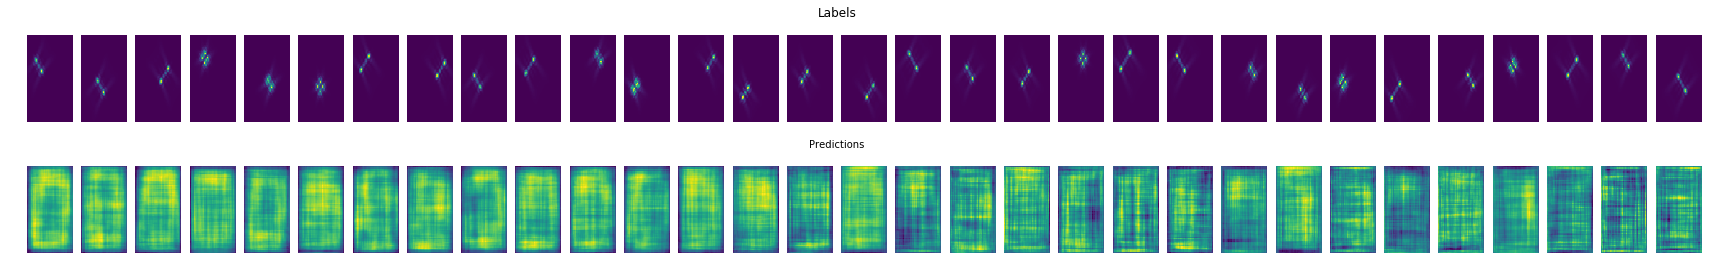

In [24]:
import numpy as np

def removeNons(y_pred, y_labels):
    """Removes the zero labels and corresponding predictions.
    Args:
        y_pred  : network output 
        y_labels: labels matrix
    """
    maxSources = y_labels.shape[-1]
    idxs = []
    for i in range(maxSources):
        if (y_labels[:,:,i] == np.zeros(y_labels[:,:,i].shape)).all():
            continue
        idxs = np.append(idxs, i).astype(int)
    y_tot = np.append(y_labels[:,:,idxs], y_pred[:,:,idxs], axis=2)
    return y_tot
    
def showPredictions(y_pred, y_labels):
        # Truncate dimensions
        y_preds = y_pred[0,:,:,:]
        y_tot = removeNons(y_preds, y_labels)
        numSources = int(y_tot.shape[-1]/2)
        fig, axes = plt.subplots(2, numSources, figsize=(30,4))
        plt.suptitle('Labels')
        plt.subplots_adjust(hspace=0.5)
        plt.figtext(0.5, 0.5, 'Predictions', ha='center', va='center')
        for i, ax in enumerate(axes.flat):
            ax.imshow(y_tot[:,:,i], aspect='auto')
            ax.axis('off')
        plt.show()

sample_xe = np.expand_dims(sample_x, axis=0)
y_pred = model.predict(x = sample_xe)
showPredictions(y_pred, sample_y)